In [3]:
# Libraries
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas_datareader.data as data
import datetime
import json
from yahoofinancials import YahooFinancials
from selenium import webdriver
from selenium.webdriver.chrome.webdriver import WebDriver
from webdriver_manager.chrome import ChromeDriverManager
import re
import requests
import warnings

driver = webdriver.Chrome()

asset_dict = {} 

warnings.filterwarnings('ignore')


def get_table(soup):
    for t in soup.select('table'):
        header = t.select('thead tr th')
        if len(header) > 2:
            if (header[0].get_text().strip() == 'Symbol'
                and header[2].get_text().strip().startswith('% Holding')):
                return t
    raise Exception('could not find symbol list table')
    
# Scrapes ETF holdings from barchart.com
def get_etf_holdings():
    '''
    etf_symbol: str
    
    return: pd.DataFrame
    '''
    url = 'https://www.barchart.com/stocks/quotes/VONE/constituents?page=all'

    # Loads the ETF constituents page and reads the holdings table
    browser = WebDriver() # webdriver.PhantomJS()
    browser.get(url)
    html = browser.page_source
    soup = BeautifulSoup(html, 'html')
    table = get_table(soup)

    # Reads the holdings table line by line and appends each asset to a
    # dictionary along with the holdings percentage
    for row in table.select('tr')[1:26]:
        try:
            cells = row.select('td')
            # print(row)
            symbol = cells[0].get_text().strip()
            # print(symbol)
            # name = cells[1].text.strip()
            celltext = cells[2].get_text().strip()
            percent = float(celltext.rstrip('%'))
            # shares = int(cells[3].text.strip().replace(',', ''))
            if symbol != "" and percent != 0.0:
                asset_dict[symbol] = {
                    'percent': percent,
                }
        except BaseException as ex:
            print(ex)
    browser.quit()
    return pd.DataFrame(asset_dict)

constituent = get_etf_holdings()

constituent.T

# Assets
russell_index = ["^RUI"]
tickers = []

# Set timeframe
start = "2019-03-31"
end = "2019-04-29"

def russell():
    # Pull data from Yahoo! Finance for Russell 1000 Index
    df = data.DataReader(russell_index, data_source="yahoo", start=start, end=end)

    percentage = df.pct_change()
    russellReturn = percentage["Adj Close"]

    return russellReturn


#russell()

def pullTickers():
    exec(open("scrapeETF.py").read())

    list(asset_dict.keys())

    for key in asset_dict.keys():
        tickers.append(key.replace('.','-'))
    return tickers


pullTickers()



['AAPL',
 'MSFT',
 'AMZN',
 'FB',
 'BRK-B',
 'JPM',
 'GOOG',
 'GOOGL',
 'JNJ',
 'V',
 'PG',
 'XOM',
 'BAC',
 'T',
 'UNH',
 'MA',
 'INTC',
 'VZ',
 'DIS',
 'HD',
 'MRK',
 'CVX',
 'PFE',
 'KO',
 'CSCO']

In [4]:
replicatedWeights = {}

marketCaps = {}

portfolioAUM = np.zeros(0)

def pullFundamentals():

    for i in tickers:
        yahoo_financials = YahooFinancials(i)
        sharesOutstanding = yahoo_financials.get_key_statistics_data()[i]['sharesOutstanding']
        
        prices = yahoo_financials.get_historical_price_data('2019-04-01', '2019-04-02', 'daily')[i]['prices'][0]['adjclose']

        mcap = sharesOutstanding * prices

        marketCaps[i] = mcap
        
        print(marketCaps)

pullFundamentals()

{'AAPL': 829533959525.7891}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938, 'AMZN': 899469915865.875}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938, 'AMZN': 899469915865.875, 'FB': 405971462761.6367}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0, 'JPM': 313468157958.9844}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0, 'JPM': 313468157958.9844, 'GOOG': 410347648937.8867}
{'AAPL': 829533959525.7891, 'MSFT': 906409833473.5938, 'AMZN': 899469915865.875, 'FB': 405971462761.6367, 'BRK-B': 283601106560.0, 'JPM': 313468157958.9844, 'GOOG': 410347648937.8867, 'GOOGL': 359247973587.8906}
{'AAPL': 829533959525.7891, 'MSFT': 9064098334

In [5]:
aggregateValue = sum(marketCaps.values())    

for i in tickers:
    weights = marketCaps[i] / aggregateValue

    replicatedWeights[i] = weights

    print(replicatedWeights)

{'AAPL': 0.09739234221474635}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525, 'AMZN': 0.10560324969451115}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525, 'AMZN': 0.10560324969451115, 'FB': 0.04766352380956778}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525, 'AMZN': 0.10560324969451115, 'FB': 0.04766352380956778, 'BRK-B': 0.033296498239037534}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525, 'AMZN': 0.10560324969451115, 'FB': 0.04766352380956778, 'BRK-B': 0.033296498239037534, 'JPM': 0.03680307208980328}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525, 'AMZN': 0.10560324969451115, 'FB': 0.04766352380956778, 'BRK-B': 0.033296498239037534, 'JPM': 0.03680307208980328, 'GOOG': 0.0481773147361218}
{'AAPL': 0.09739234221474635, 'MSFT': 0.10641803831507525, 'AMZN': 0.10560324969451115, 'FB': 0.04766352380956778, 'BRK-B': 0.033296498239037534, 'JPM': 0.03680307208980328, 'GOOG': 0.04

In [6]:
rweights = list(replicatedWeights.values())

print(rweights)

[0.09739234221474635, 0.10641803831507525, 0.10560324969451115, 0.04766352380956778, 0.033296498239037534, 0.03680307208980328, 0.0481773147361218, 0.04217790143712408, 0.042044108949976663, 0.03145948466656365, 0.029283466365362564, 0.03917453626795667, 0.029097101623249966, 0.025861225571563604, 0.02696028488348514, 0.027850383984715225, 0.027333702556831888, 0.027528005616959873, 0.02355841732927438, 0.024572925622104277, 0.02440367657732891, 0.0269216528291101, 0.026799011716765964, 0.02297840395544101, 0.026641670947322893]


In [9]:
weightedPrice = {}


def replicateETF():
    prices = data.DataReader(tickers, data_source="yahoo", start=start, end=end)['Adj Close']
    x = 0
    for i in tickers:
        prices[i] *= rweights[x]
        x += 1

    prices['ETF'] = prices.sum(axis = 1)
    
    return prices['ETF']

replicateETF()


Date
2019-04-01    399.909751
2019-04-02    400.856418
2019-04-03    402.368491
2019-04-04    403.134960
2019-04-05    404.744723
2019-04-08    406.168417
2019-04-09    403.915280
2019-04-10    405.730139
2019-04-11    405.267201
2019-04-12    406.860391
2019-04-15    407.679689
2019-04-16    409.981289
2019-04-17    411.425211
2019-04-18    411.364068
2019-04-22    415.748455
2019-04-23    421.985511
2019-04-24    418.515678
2019-04-25    420.066600
2019-04-26    426.203472
2019-04-29    426.709743
2019-04-30    416.556266
Name: ETF, dtype: float64

In [60]:
etfReturn = replicateETF().pct_change()[1:]


print(etfReturn)

Date
2019-04-02    0.002367
2019-04-03    0.003772
2019-04-04    0.001905
2019-04-05    0.003993
2019-04-08    0.003518
2019-04-09   -0.005547
2019-04-10    0.004493
2019-04-11   -0.001141
2019-04-12    0.003931
2019-04-15    0.002014
2019-04-16    0.005646
2019-04-17    0.003522
2019-04-18   -0.000149
2019-04-22    0.010658
2019-04-23    0.015002
2019-04-24   -0.008223
2019-04-25    0.003706
2019-04-26    0.014609
2019-04-29    0.001188
2019-04-30   -0.023795
Name: ETF, dtype: float64


In [96]:
etfTotalReturn = etfReturn.values

print(etfTotalReturn)

[ 0.0023672   0.0037721   0.00190489  0.00399311  0.00351751 -0.0055473
  0.00449317 -0.001141    0.00393121  0.00201371  0.00564561  0.00352192
 -0.00014861  0.01065817  0.015002   -0.00822264  0.00370577  0.01460928
  0.00118786 -0.02379481]


In [38]:
def russell():
    # Pull data from Yahoo! Finance for Russell 1000 Index
    df = data.DataReader(russell_index, data_source="yahoo", start=start, end=end)

    #percentage = df["Adj Close"].pct_change()
    #russellReturn = percentage[1:]    

    return df["Adj Close"]


russell()

Symbols,^RUI
Date,
2019-04-01,1588.650024
2019-04-02,1588.569946
2019-04-03,1592.479980
2019-04-04,1595.109985
2019-04-05,1602.880005
2019-04-08,1604.560059
2019-04-09,1594.420044
2019-04-10,1600.930054
2019-04-11,1601.270020


In [98]:
russellReturn = russell().pct_change()[1:]


russellTotalReturn = russellReturn.values.flatten()


print(russellTotalReturn)

[-5.04063977e-05  2.46135475e-03  1.65151519e-03  4.87114970e-03
  1.04814690e-03 -6.31949835e-03  4.08299544e-03  2.12355199e-04
  6.67591429e-03 -7.07222683e-04  3.22829086e-04 -2.99126590e-03
  1.50015820e-03  8.32830375e-04  9.20339205e-03 -1.95677268e-03
 -8.69366457e-04  2.85096891e-03  3.24900888e-03  9.01601252e-04]


In [127]:

def trackingError():

    returnDifference = etfTotalReturn - russellTotalReturn
    
    squaredValues = returnDifference ** 2

    sumation = squaredValues.sum()

    Error = (sumation / (20 - 1)) ** (1/2)


    print("Tracking Error is " + "{:.2%}".format(Error))


trackingError()






Tracking Error is 0.74%


[]

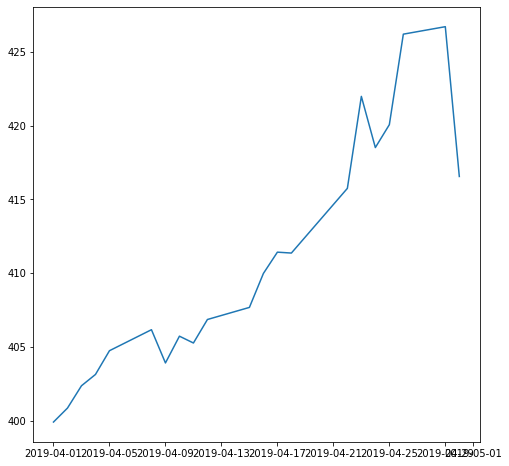

In [125]:
import seaborn as sns


fig=plt.figure(figsize = (8,8))
fig.show()
ax=fig.add_subplot(111)

plt.plot(replicateETF())
plt.plot()





[]

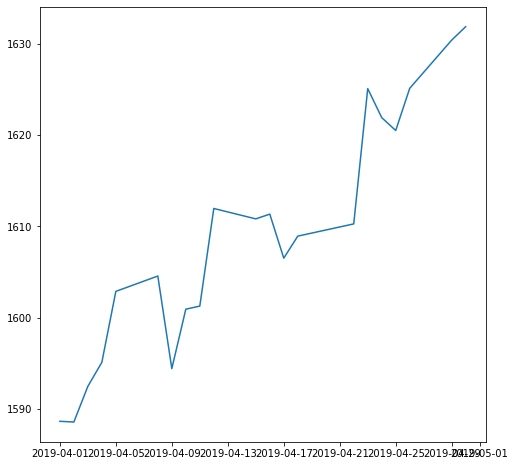

In [124]:
fig=plt.figure(figsize = (8,8))
fig.show()
ax=fig.add_subplot(111)

plt.plot(russell())
plt.plot()